In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical

from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
base_skin_dir = 'dane'

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# lesion_type_dict = {
#     'nv': 'Znamię melanocytowe',
#     'mel': 'Czerniak',
#     'bkl': 'Łagodne zmiany przypominające rogowacenie',
#     'bcc': 'Rak podstawnokomórkowy',
#     'akiec': 'Rogowacenie słoneczne',
#     'vasc': 'Zmiany naczyniowe',
#     'df': 'Włókniak'
# }

lesion_type_dict = {
    'mel': 'Czerniak',
    'bcc': 'Rak podstawnokomórkowy',
    'akiec': 'Rogowacenie słoneczne',
    'df': 'Włókniak'
    'vasc': 'Zmiany naczyniowe',
    'nv': 'Znamię melanocytowe',
    'bkl': 'Łagodne zmiany przypominające rogowacenie',
}

In [5]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

<AxesSubplot:xlabel='age', ylabel='cell_type'>

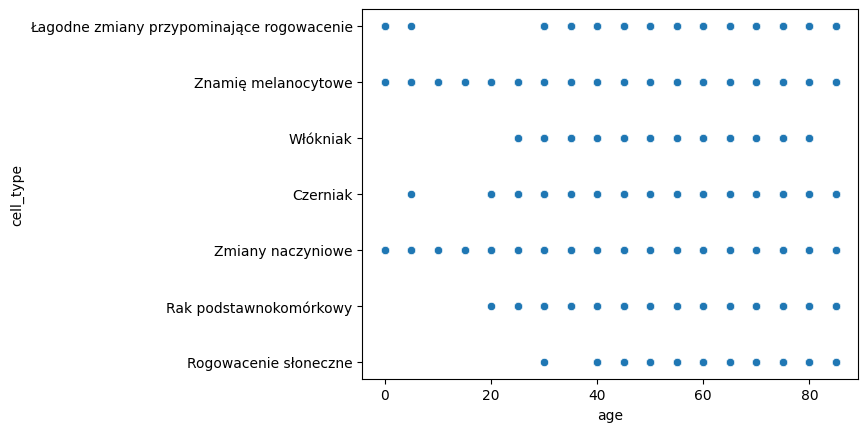

In [7]:
sns.scatterplot(x='age',y='cell_type',data=skin_df)

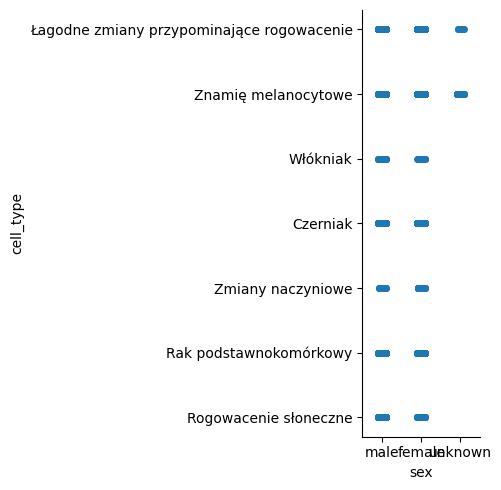

In [8]:
sns.catplot(x='sex',y='cell_type',data=skin_df)

In [10]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

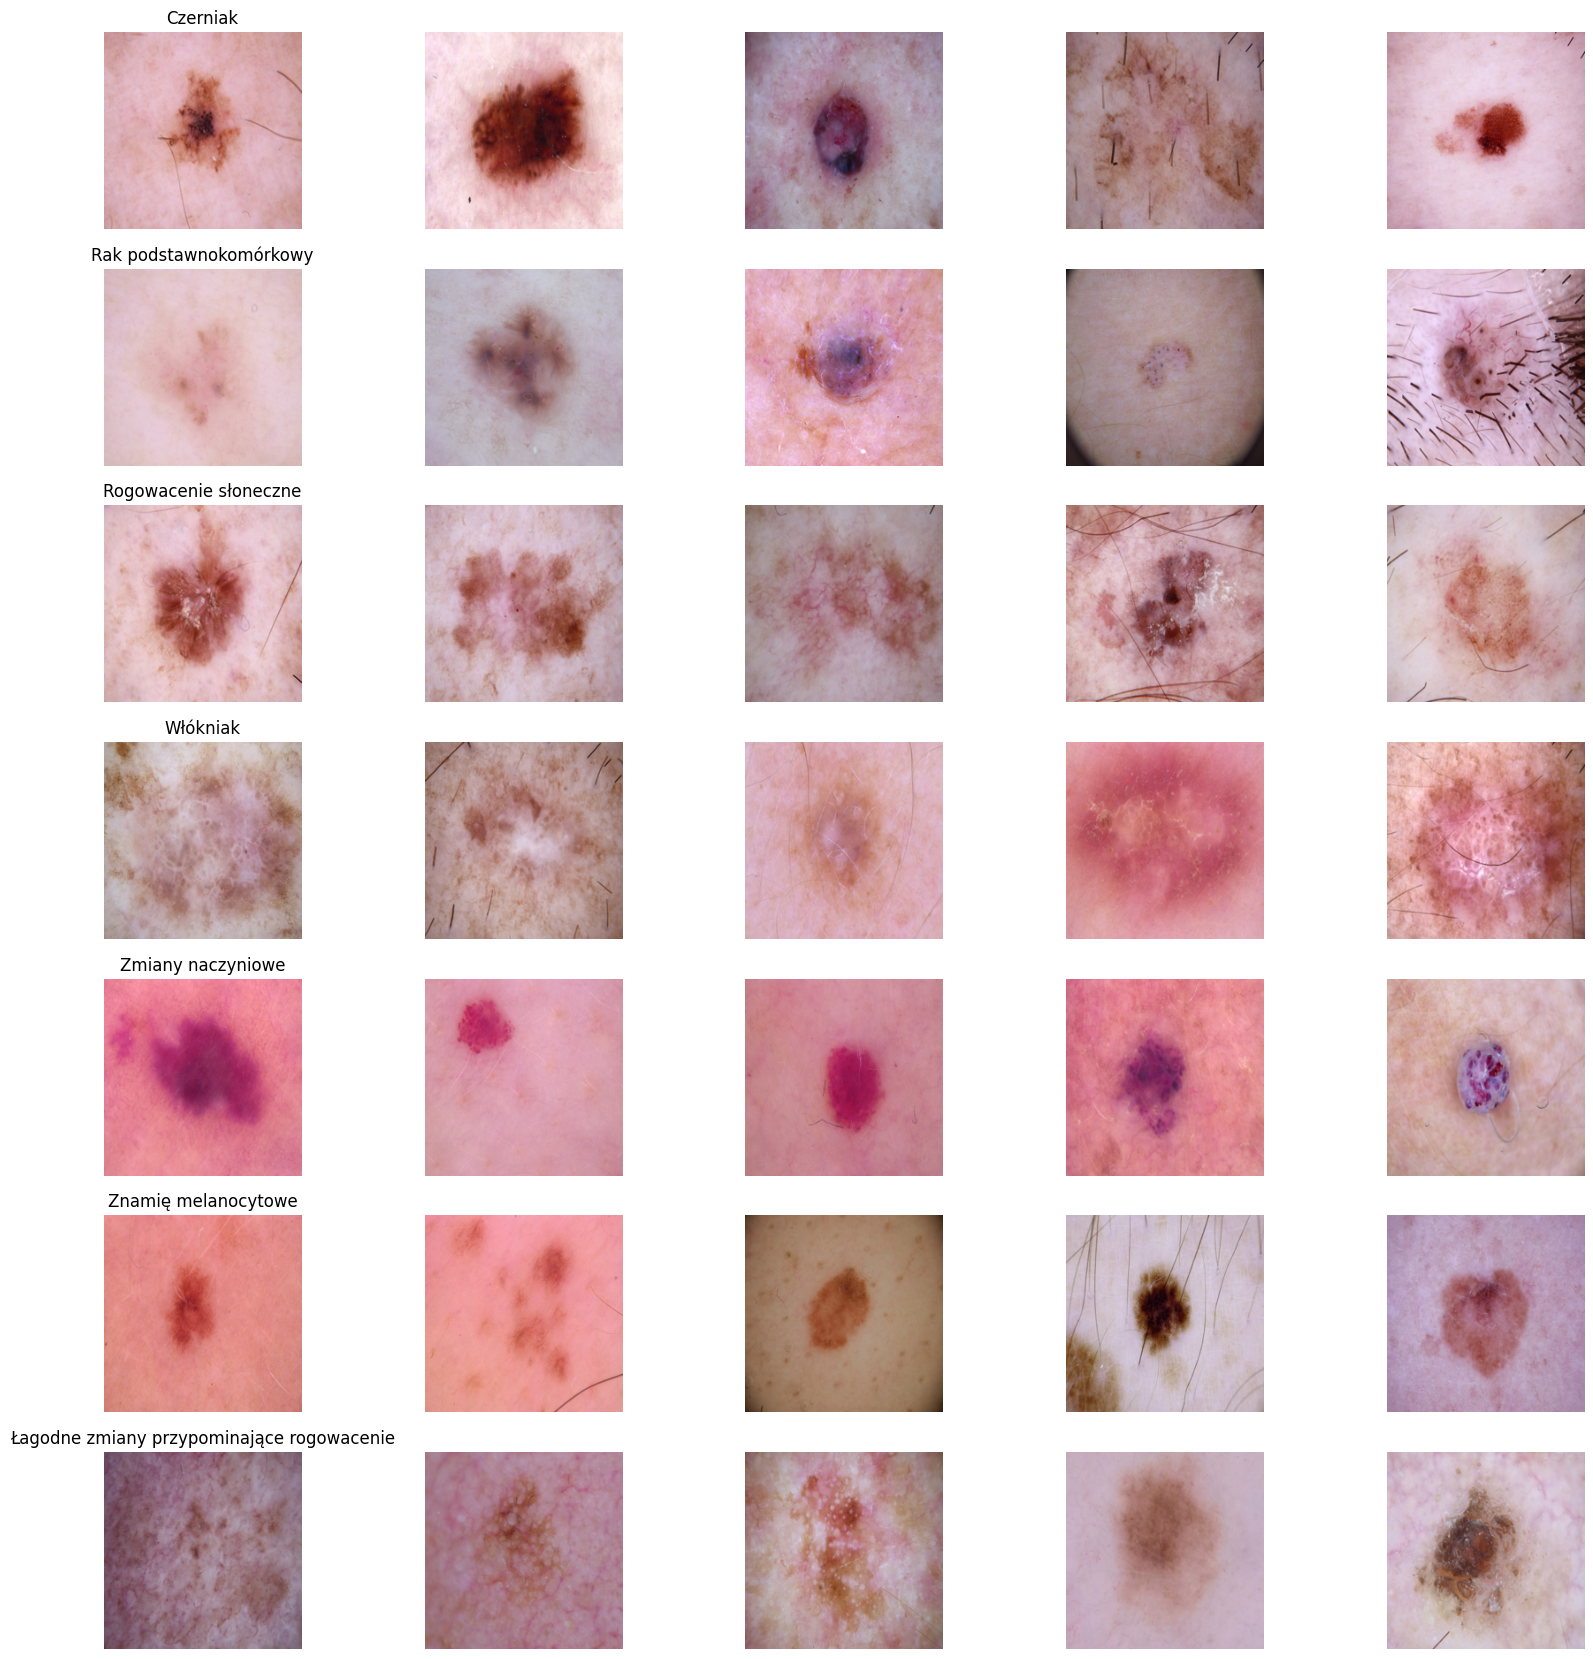

In [11]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('samples.png', dpi=300)

In [12]:
df = skin_df.groupby("lesion_id").count()
df = df[df['image_id'] == 1]
df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1


In [13]:
unique_list = list(df['lesion_id'])

def indentify_duplicates(x):

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

df_data = skin_df.copy()

df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(indentify_duplicates)

In [14]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [15]:
df = df_data[df_data['duplicates'] == 'no_duplicates']
df.shape


(5514, 12)

In [71]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [17]:
df=df.drop(columns=['duplicates'],axis=1)

In [18]:
features_val=df.drop(columns=['cell_type_idx'],axis=1)
target_val=df['cell_type_idx']

In [19]:
_, x_val, _, y_val = train_test_split(features_val,target_val, test_size=0.2, random_state=101)

In [20]:
val_list = list(x_val['image_id'])

def identify_val_rows(x):

    if str(x) in val_list:
        return 'val'
    else:
        return 'not_val'

df['val_or_not_val'] = df['image_id']
df['val_or_not_val'] = df['val_or_not_val'].apply(identify_val_rows)

df_not_val = df[df['val_or_not_val'] == 'not_val']

print(len(df_not_val)) 
print(len(x_val))

4411
1103


In [21]:
df_not_val = df_not_val.drop(columns=['val_or_not_val'],axis=1)

features_test=df_not_val.drop(columns=['cell_type_idx'],axis=1)
target_test=df_not_val['cell_type_idx']

In [22]:
_, x_test, _, y_test = train_test_split(features_test,target_test, test_size=0.25, random_state=101)

In [23]:
val_list = list(x_val['image_id'])
test_list =  list(x_test['image_id'])

def identify_train(x):

    if str(x) in val_list or str(x) in test_list:
        return 'val_or_test'
    else:
        return 'train'

df_data['train_or_not'] = df_data['image_id']
df_data['train_or_not'] = df_data['train_or_not'].apply(identify_train)

df_train = df_data[df_data['train_or_not'] == 'train']

print(len(df_train))

7809


In [24]:
y_train = df_train['cell_type_idx']

In [25]:
x_train = np.asarray(df_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())
x_val = np.asarray(x_val['image'].tolist())

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)

In [26]:
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
x_val = x_val.reshape(x_val.shape[0], *(224, 224, 3))

In [35]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [36]:
import tensorflow as tf
base_model = tf.keras.applications.resnet_v2.ResNet152V2(include_top=False)

base_model.trainable = False

In [37]:
input_shape = (224, 224, 3)
num_classes = 7

In [38]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation= 'relu')(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [39]:
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
filepath = 'model_final.h5'

lr_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 3,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.0001
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

callbacks = [lr_reduction, checkpoint]

In [41]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 58,594,823
Trainable params: 263,175
Non-trainable params: 58,331,648
_________________________________________

In [42]:
epochs = 30
batch_size = 32

train_iterator = datagen.flow(x_train, y_train, batch_size=batch_size)
val_iterator = datagen.flow(x_val, y_val, batch_size=batch_size)
test_iterator = datagen.flow(x_test, y_test, batch_size=batch_size)

history_normalized = model.fit(
    train_iterator,
    epochs = epochs,
    validation_data = val_iterator,
    verbose = 1,
    steps_per_epoch = len(x_train) // batch_size,
    callbacks = callbacks
)

Epoch 1/30
244/244 [==============================] - ETA: 0s - loss: 0.9117 - accuracy: 0.6740
Epoch 1: val_accuracy improved from -inf to 0.84316, saving model to model_final.h5
244/244 [==============================] - 462s 2s/step - loss: 0.9117 - accuracy: 0.6740 - val_loss: 0.4851 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 2/30
244/244 [==============================] - ETA: 0s - loss: 0.7619 - accuracy: 0.7187
Epoch 2: val_accuracy improved from 0.84316 to 0.86854, saving model to model_final.h5
244/244 [==============================] - 447s 2s/step - loss: 0.7619 - accuracy: 0.7187 - val_loss: 0.4554 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 3/30
244/244 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.7432
Epoch 3: val_accuracy did not improve from 0.86854
244/244 [==============================] - 455s 2s/step - loss: 0.6991 - accuracy: 0.7432 - val_loss: 0.4390 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 4/30
244/244 [==============================] - E

In [43]:
model.save("model_final_normalized.h5")

In [50]:
x_val_normalized = x_val / 255.0
x_test_normalized = x_test / 255.0

In [51]:
model_before_tuning = keras.models.load_model("model_final_normalized.h5")

In [54]:
loss_nt, accuracy_nt = model_before_tuning.evaluate(x_test_normalized, y_test, verbose=1)
loss_v_nt, accuracy_v_nt = model_before_tuning.evaluate(x_val_normalized, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v_nt, loss_v_nt))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy_nt, loss_nt))

35/35 [==============================] - 57s 2s/step - loss: 0.4752 - accuracy: 0.8676
Validation: accuracy = 0.867634  ;  loss_v = 0.475223
Test: accuracy = 0.858568  ;  loss = 0.451751


In [49]:
# tuning: 

loss, accuracy = model.evaluate(x_test_normalized, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_val_normalized, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

35/35 [==============================] - 58s 2s/step - loss: 0.6031 - accuracy: 0.8894
Validation: accuracy = 0.889393  ;  loss_v = 0.603145
Test: accuracy = 0.884860  ;  loss = 0.609018


tunning: 

In [45]:
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate = 0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
tunned_history_normalized = model.fit(
    train_iterator,
    epochs = epochs // 2,
    validation_data = val_iterator,
    verbose = 1,
    steps_per_epoch = len(x_train) // batch_size
)

Epoch 1/15
244/244 [==============================] - 1530s 6s/step - loss: 0.4489 - accuracy: 0.8296 - val_loss: 0.4759 - val_accuracy: 0.8649
Epoch 2/15
244/244 [==============================] - 1506s 6s/step - loss: 0.3544 - accuracy: 0.8679 - val_loss: 0.4295 - val_accuracy: 0.8685
Epoch 3/15
244/244 [==============================] - 1475s 6s/step - loss: 0.3043 - accuracy: 0.8854 - val_loss: 0.4349 - val_accuracy: 0.8740
Epoch 4/15
244/244 [==============================] - 1485s 6s/step - loss: 0.2499 - accuracy: 0.9111 - val_loss: 0.4706 - val_accuracy: 0.8749
Epoch 5/15
244/244 [==============================] - 1477s 6s/step - loss: 0.1999 - accuracy: 0.9245 - val_loss: 0.5832 - val_accuracy: 0.8704
Epoch 6/15
244/244 [==============================] - 1487s 6s/step - loss: 0.2030 - accuracy: 0.9244 - val_loss: 0.4780 - val_accuracy: 0.8794
Epoch 7/15
244/244 [==============================] - 1472s 6s/step - loss: 0.1579 - accuracy: 0.9427 - val_loss: 0.5341 - val_accuracy:

In [47]:
model.save("model_final_tunned.h5")

In [48]:
# ewaluacja dla nieznormalizowanych danych
loss2, accuracy2 = model.evaluate(x_test, y_test, verbose=1)
loss_v2, accuracy_v2 = model.evaluate(x_val, y_val, verbose=1)
print("Validation after tunning: accuracy = %f  ;  loss_v = %f" % (accuracy_v2, loss_v2))
print("Test after tunning: accuracy = %f  ;  loss = %f" % (accuracy2, loss2))

35/35 [==============================] - 55s 2s/step - loss: 2574.0793 - accuracy: 0.8024
Validation after tunning: accuracy = 0.802357  ;  loss_v = 2574.079346
Test after tunning: accuracy = 0.788758  ;  loss = 2796.343750


In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


35/35 [==============================] - 61s 2s/step


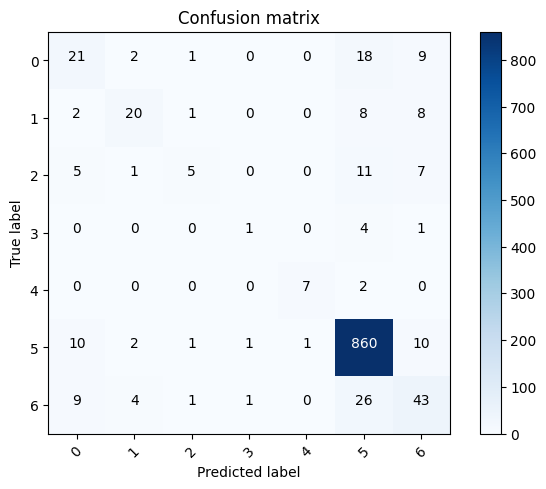

In [59]:
Y_pred_nt = model_before_tuning.predict(x_val_normalized)
Y_pred_classes = np.argmax(Y_pred_nt,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(7))

35/35 [==============================] - 56s 2s/step


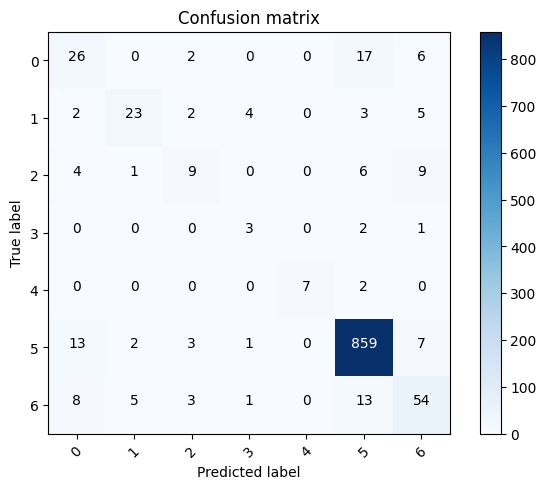

In [60]:
Y_pred_t = model.predict(x_val_normalized)
Y_pred_classes = np.argmax(Y_pred_t,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 
confusion_mtx_t = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx_t, classes = range(7))

In [63]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

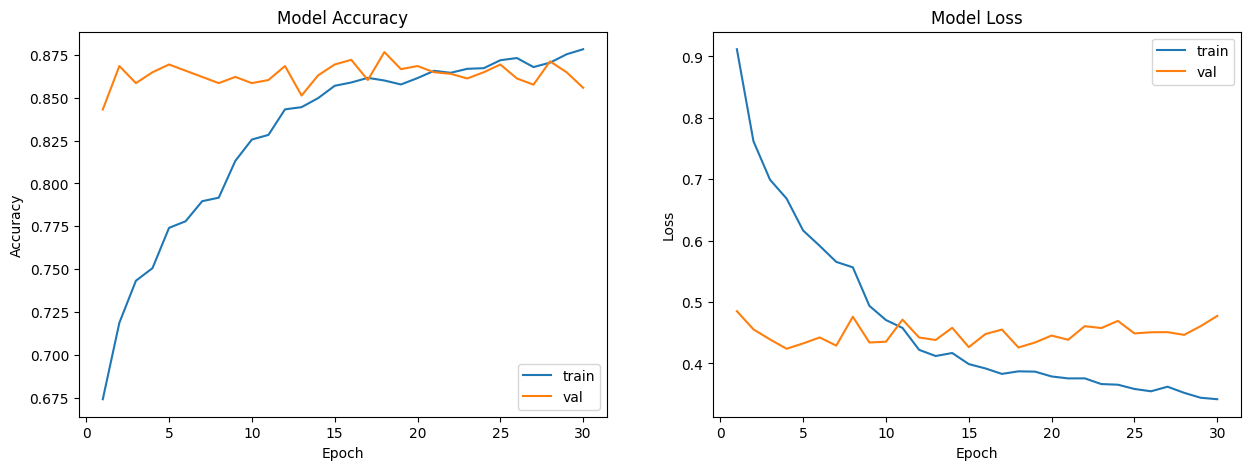

In [65]:
plot_model_history(history_normalized)

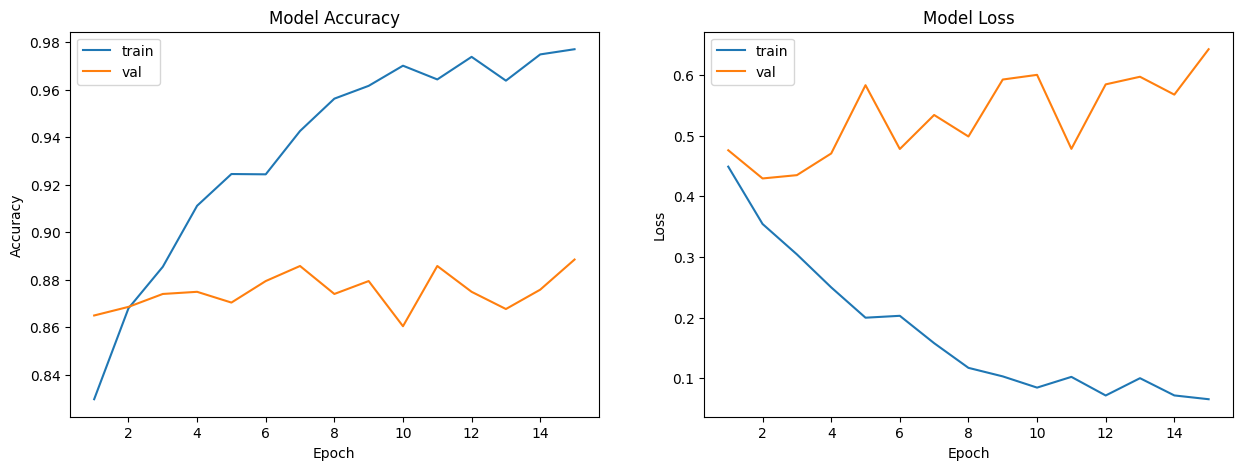

In [66]:
plot_model_history(tunned_history_normalized)

In [82]:
def vec_to_label(vec):
    max_val = max(vec)
    return [idx for idx, v in enumerate(vec) if v == max_val][0]

Counter([vec_to_label(v) for v in y_test])  # testowy

Counter({6: 99, 5: 870, 4: 15, 0: 43, 2: 39, 1: 29, 3: 8})

In [83]:
Counter([vec_to_label(v) for v in y_val]) # walidacyjny

Counter({5: 885, 3: 6, 6: 84, 2: 29, 0: 51, 1: 39, 4: 9})

In [84]:
Counter([vec_to_label(v) for v in y_train]) # treningowy

Counter({6: 916, 5: 4950, 3: 101, 0: 1019, 4: 118, 1: 446, 2: 259})